In [1]:
import os
import sys
os.environ['QT_QPA_PLATFORM'] = 'offscreen'

from osgeo import ogr
from qgis.core import *
from qgis.gui import *
from qgis import processing

from qgis.PyQt.QtGui import QColor, QImage
from qgis.PyQt.QtCore import QSize, QBuffer, QIODevice

qgs = QgsApplication([], False)
qgs.initQgis()
print(QgsApplication.showSettings())

Application state:
QGIS_PREFIX_PATH env var:		C:/OSGEO4~1/apps/qgis
Prefix:		C:/OSGEO4~1/apps/qgis
Plugin Path:		C:/OSGEO4~1/apps/qgis/plugins
Package Data Path:	C:/OSGEO4~1/apps/qgis/.
Active Theme Name:	
Active Theme Path:	C:/OSGEO4~1/apps/qgis/./resources/themes\\icons/
Default Theme Path:	:/images/themes/default/
SVG Search Paths:	C:/OSGEO4~1/apps/qgis/./svg/
		C:/Users/bruno/AppData/Roaming/python3\profiles\default/svg/
User DB Path:	C:/OSGEO4~1/apps/qgis/./resources/qgis.db
Auth DB Path:	C:/Users/bruno/AppData/Roaming/python3\profiles\default/qgis-auth.db



In [71]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jgrocha/covid-pt/master/situacao_epidemiologica.csv")
df = df.sort_values(by=['data_relatorio'])
#df.drop('id', 1)
df = df.sort_index(1, ignore_index= True)
df.head()

,aguarda_resultados,confirmados,confirmados_feminino_0_9,confirmados_feminino_10_19,confirmados_feminino_20_29,confirmados_feminino_30_39,confirmados_feminino_40_49,confirmados_feminino_50_59,confirmados_feminino_60_69,confirmados_feminino_70_79,...,obitos_masculino_80_sup,recuperados,sintoma_cefaleia,sintoma_dores,sintoma_febre,sintoma_fraqueza,sintoma_respiratoria,sintoma_tosse,suspeitos,url
0,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1,2,2,1,NaN,2,101,https://covid19.min-saude.pt/wp-content/upload...
1,NaN,6,NaN,NaN,NaN,0.0,1.0,NaN,0.0,NaN,...,NaN,NaN,3,3,5,1,NaN,3,117,https://covid19.min-saude.pt/wp-content/upload...
2,NaN,9,NaN,NaN,NaN,0.0,1.0,0.0,0.0,NaN,...,NaN,NaN,3,5,8,3,1.0,6,147,https://covid19.min-saude.pt/wp-content/upload...
3,30.0,13,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,...,NaN,NaN,3,6,11,4,2.0,8,181,https://covid19.min-saude.pt/wp-content/upload...
4,47.0,21,NaN,1.0,0.0,1.0,2.0,0.0,1.0,1.0,...,NaN,NaN,9,10,13,9,3.0,15,224,https://covid19.min-saude.pt/wp-content/upload...


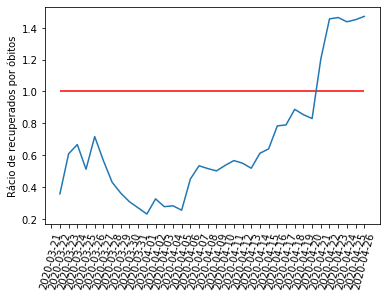

In [72]:
import matplotlib.pyplot as plt

first_date = dates[0]
for i in range(0, dates.size):
    if df.obitos[i] > 0:
        first_date = dates[i]
        break

dates = df.data_relatorio
ratio = df.recuperados / df.obitos

plt.plot(dates, ratio)
plt.hlines(1, first_date, dates[dates.size - 1], colors='red')

plt.ylabel("Rácio de recuperados por óbitos")
tmp = plt.xticks(rotation=75)

# por ao lado o mesmo gráfico mas sem ser em rácio